In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import cv2 as cv
import glob as glob
import nibabel as nib
import pickle
import imgaug as ia
import imgaug.augmenters as iaa
from tqdm import tqdm
import gc
import warnings

In [87]:
!pip install opendatasets

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import opendatasets as od
dataset_url='https://www.kaggle.com/andrewmvd/covid19-ct-scans'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alankritnokhwal
Your Kaggle Key: ··········


  1%|          | 10.0M/1.03G [00:00<00:10, 100MB/s]

100%|██████████| 1.03G/1.03G [00:08<00:00, 132MB/s]


In [89]:
file_path='/content/covid19-ct-scans/metadata.csv'

In [90]:
raw_data=pd.read_csv(file_path)
raw_data.head(4)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
1,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
2,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
3,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...


In [91]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ct_scan                  20 non-null     object
 1   lung_mask                20 non-null     object
 2   infection_mask           20 non-null     object
 3   lung_and_infection_mask  20 non-null     object
dtypes: object(4)
memory usage: 768.0+ bytes


In [92]:
for x in ['ct_scan','lung_mask','infection_mask','lung_and_infection_mask']:  
  i=0
  while(i<20):
    raw_data.loc[i,x]=raw_data.loc[i,x].replace('input','content')
    i=i+1

####The files are provided in NifTi format (*.nii) to read it we have to use the nibabel package.

In [93]:
import nibabel as nib
def read_nii(filepath):
    ni_object = nib.load(filepath)
    array   = ni_object.get_fdata()
    array   = np.rot90(np.array(array))
    return(array,ni_object)

In [94]:
ct_sample,ct_nifti   = read_nii(raw_data.loc[0,'ct_scan'])
lung_sample,lung_nifti = read_nii(raw_data.loc[0,'lung_mask'])
infection_sample ,infection_nifti= read_nii(raw_data.loc[0,'infection_mask'])
li_sample,li_nifti  = read_nii(raw_data.loc[0,'lung_and_infection_mask'])

In [95]:
print(ct_nifti.header.get_slope_inter())

(None, None)


### Visualization and Intution of sample CT scans.

In [96]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')

    plt.subplot(1,4,2)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Lung Mask')

    plt.subplot(1,4,3)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[2], alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')

    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[3], alpha=0.5, cmap=color_map)
    plt.title('Lung and Infection Mask')

    plt.show()

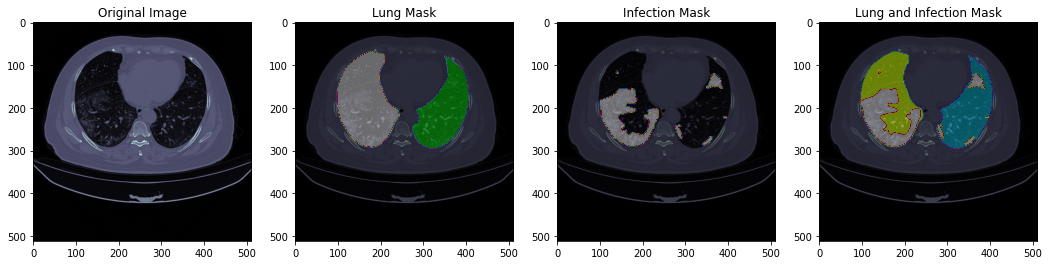

In [97]:
plot_sample([ct_sample[:,:,120], lung_sample[:,:,120], infection_sample[:,:,120], li_sample[:,:,120]])

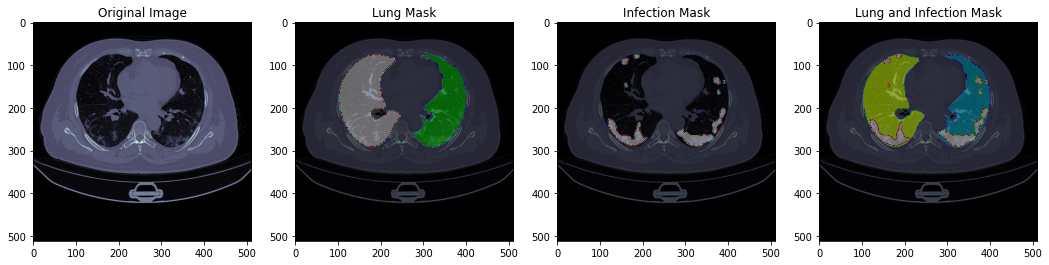

In [98]:
  plot_sample([ct_sample[:,:,150], lung_sample[:,:,150], infection_sample[:,:,150], li_sample[:,:,150]])

## Improving contract of the CT-scans


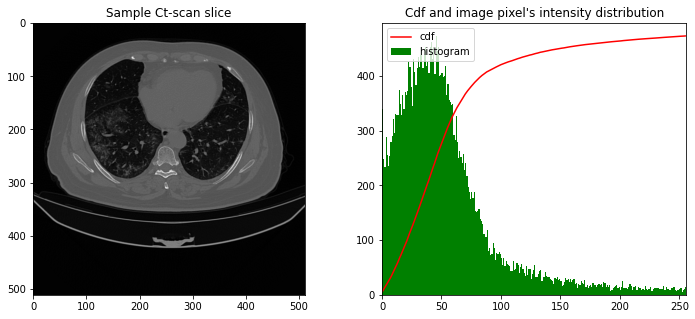

In [99]:
def plot_sample_and_hist(img,cmap='gray'):
  hist,bins = np.histogram(img.flatten(),256,[0,256])
  # here hist is the image pixel's intensity distribution
  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.imshow(img,cmap=cmap)
  plt.title('Sample Ct-scan slice')

  plt.subplot(1,2,2)
  plt.hist(img.flatten(),256,[0,256], color = 'g')

  cdf=hist.cumsum()
  cdf_normalized = cdf * hist.max()/ cdf.max()

  plt.plot(cdf_normalized, color = 'r')
  plt.xlim([0,256])
  plt.legend(('cdf','histogram'), loc = 'upper left')
  plt.title("Cdf and image pixel's intensity distribution")
  plt.show()

plot_sample_and_hist(ct_sample[...,120])

#### Here Image pixel values are confined to a some specific range of values ,we need to strech its pixel's intensity distribution histogram in order to improve the image contrast .We will perform an alogorithm **contract limited adaptive historam equalization [(CLAHE)](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization)** to do so.  

In [100]:
clahe_image = cv.createCLAHE(clipLimit=7.0, tileGridSize=(8,8))
def clahe_enhancer(img, clahe, axes):
  img = np.uint8(img*255)
  clahe_img = clahe_image.apply(img)
  if len(axes) > 0 :    
    axes[0].imshow(img,cmap='gist_gray')
    axes[0].set_title("Original CT-scan Slice")
    axes[0].set_xticks([]); axes[0].set_yticks([])
 
    axes[1].imshow(clahe_img,cmap='gist_gray')
    axes[1].set_title("After appling CLAHE")
    axes[1].set_xticks([]); axes[1].set_yticks([])
 
    # Display histograms of CLAHE Enhanced Images vs Original CT Scan images
    if len(axes) > 2 :
      axes[2].hist(img.flatten(),56,[0,256], alpha=0.7, color='blue', label='Original CT-scan Slice')
      axes[2].hist(clahe_img.flatten(),56,[0,256], alpha=0.3, color='green', label="After appling CLAHE")
      axes[2].legend()
 
  return(clahe_img)

(3, 3)


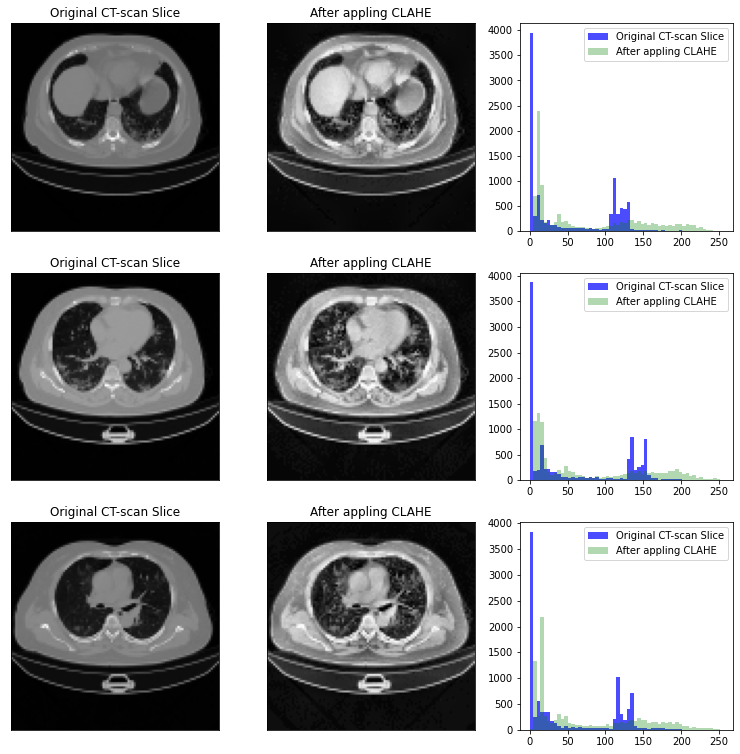

In [101]:
three_ct=ct_sample[...,np.arange(100,200,40)]
a = np.reshape(np.rollaxis(three_ct, 2),(three_ct.shape[2],three_ct.shape[0],three_ct.shape[1], 1))

fig, axes = plt.subplots(3, 3, figsize=(13,13))

for slice in range(a.shape[0]):
    img = cv.resize(a[slice], dsize=(100,100), interpolation=cv.INTER_AREA) 
    img = (img - img.min())/(img.max() - img.min())
    clahe_img = clahe_enhancer(img, clahe_image, list(axes[slice,: ])) 
print(axes.shape)    

##Cropping out the part of images ,that contain non required information

In [102]:
img_size=128
def crop_lung(img, boundaries):
  minx, miny, maxx, maxy = boundaries
  return img[miny:miny+maxy, minx:minx+maxx]

def lung_mask_crop(img, mask, show=False):
  ht, wd = mask.shape
  retval, thresh = cv.threshold(mask.astype('uint8'), 0.5, 1, 0)
  contours, hierarcy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  for cnt in contours:
    area=cv.contourArea(cnt)
    # print(area)
    if area>25:
      img_cnt = cv.drawContours(mask, cnt, -1, (255,255,255), 1)
  if len(contours) < 2 :
      raise Exception("Error")
  x0, y0, w0, h0 = cv.boundingRect(contours[0])
  # print(x0, y0, w0, h0)
  x1, y1, w1, h1 = cv.boundingRect(contours[1])

  B = [min(x0,x1)-round(0.05*wd), min(y0,y1)-round(0.05*ht), max(x0+w0,x1+w1)-min(x0,x1)+round(0.1*wd), 
        max(y0+h0,y1+h1)-min(y0,y1)+round(0.1*ht)]
  B = [max(B[0],0), max(B[1],0), min(B[2], wd), min(B[3], ht)]
  cct_img = crop_lung(img, B)
  rect = patches.Rectangle((B[0],B[1]),B[2],B[3],linewidth=2,edgecolor='b',facecolor='none')
  img_boundry=img.copy()
  cv.putText(img_boundry,'TO CROP',(B[0],B[1]),cv.FONT_HERSHEY_PLAIN,0.7,(0,0,255),1)

  ht, wd = img.shape
  img = (img-np.mean(img))/np.std(img)
  middle = img[int(wd/5):int(wd/5*4),int(ht/5):int(ht/5*4)] 
  mean = np.mean(middle)  
  imgmax = np.max(img)
  imgmin = np.min(img)
  img[img==imgmax]=mean
  img[img==imgmin]=mean

  
  if show:
    fig, ax = plt.subplots(1,4, figsize=[11,11])
    ax[0].set_title("CT-scan slice orignal")
    ax[0].imshow(img, cmap='bone')
    ax[0].axis('off')

    ax[1].set_title("Contours")
    ax[1].imshow(img_cnt, cmap='bone')
    ax[1].axis('off')
    
    ax[2].set_title("Bounding Box")
    ax[2].imshow(img_boundry, cmap='bone')
    ax[2].add_patch(rect)
    ax[2].axis('off')
    
    ax[3].set_title("Cropped CT-scan")
    ax[3].imshow(img, cmap='bone')
    ax[3].axis('off')
    plt.show()

  return B

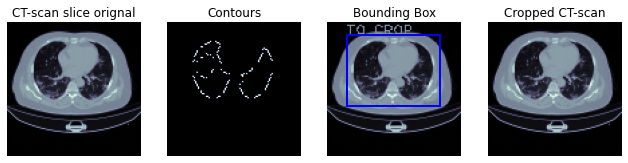

In [103]:
lung10slice=lung_sample[...,range(100,200,10)]
a_lung = np.reshape(np.rollaxis(lung10slice, 2),(lung10slice.shape[2],
                                                  lung10slice.shape[0],
                                                  lung10slice.shape[1],
                                                  1))
ct_scan_1_slice = cv.resize(a[1,...], dsize=(100, 100), interpolation=cv.INTER_AREA)
lmask_1_slice = cv.resize(a_lung[1], dsize=(100, 100), interpolation=cv.INTER_AREA)
Boundary=lung_mask_crop(ct_scan_1_slice, lmask_1_slice, show=True)

In [104]:
ct_sample[...,np.arange(100,200,20)].shape

(512, 512, 5)

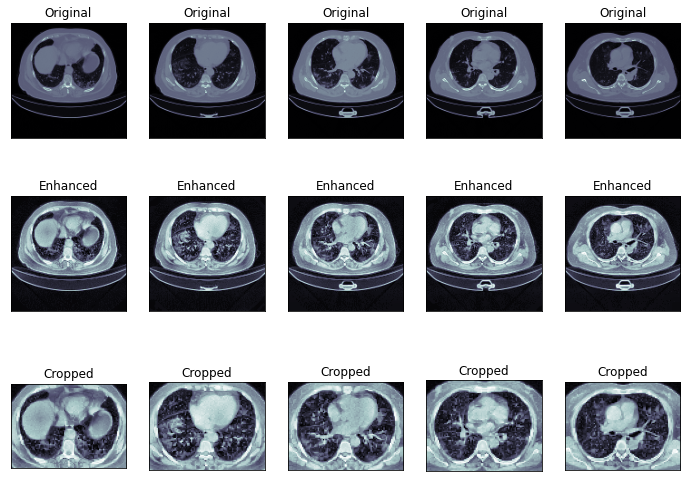

In [105]:
a=ct_sample[...,np.arange(100,200,20)]
a = np.reshape(np.rollaxis(a, 2),(a.shape[2],a.shape[0],a.shape[1], 1))

fig, axes = plt.subplots(3, 5, figsize=(12,9))


for ii in range(a.shape[0]):
    img = cv.resize(a[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    lmask = cv.resize(a_lung[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)

    axes[0,ii].imshow(img, cmap='bone')
    axes[0,ii].set_title('Original')
    axes[0,ii].set_xticks([]); axes[0,ii].set_yticks([])
    
    clahe_img = clahe_enhancer(img, clahe_image, [])
    axes[1,ii].imshow(clahe_img, cmap='bone')
    axes[1,ii].set_title('Enhanced')
    axes[1,ii].set_xticks([]); axes[1,ii].set_yticks([])

    bounds = lung_mask_crop(img, lmask)
    cropped_img = crop_lung(clahe_img, bounds)
    axes[2,ii].imshow(cropped_img, cmap='bone')
    axes[2,ii].set_title('Cropped')
    axes[2,ii].set_xticks([]); axes[2,ii].set_yticks([])

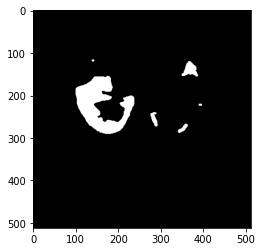

In [106]:
plt.imshow(infection_sample[...,120],cmap='gray')

In [107]:
np.unique(infection_sample[...,120])

array([0., 1.])

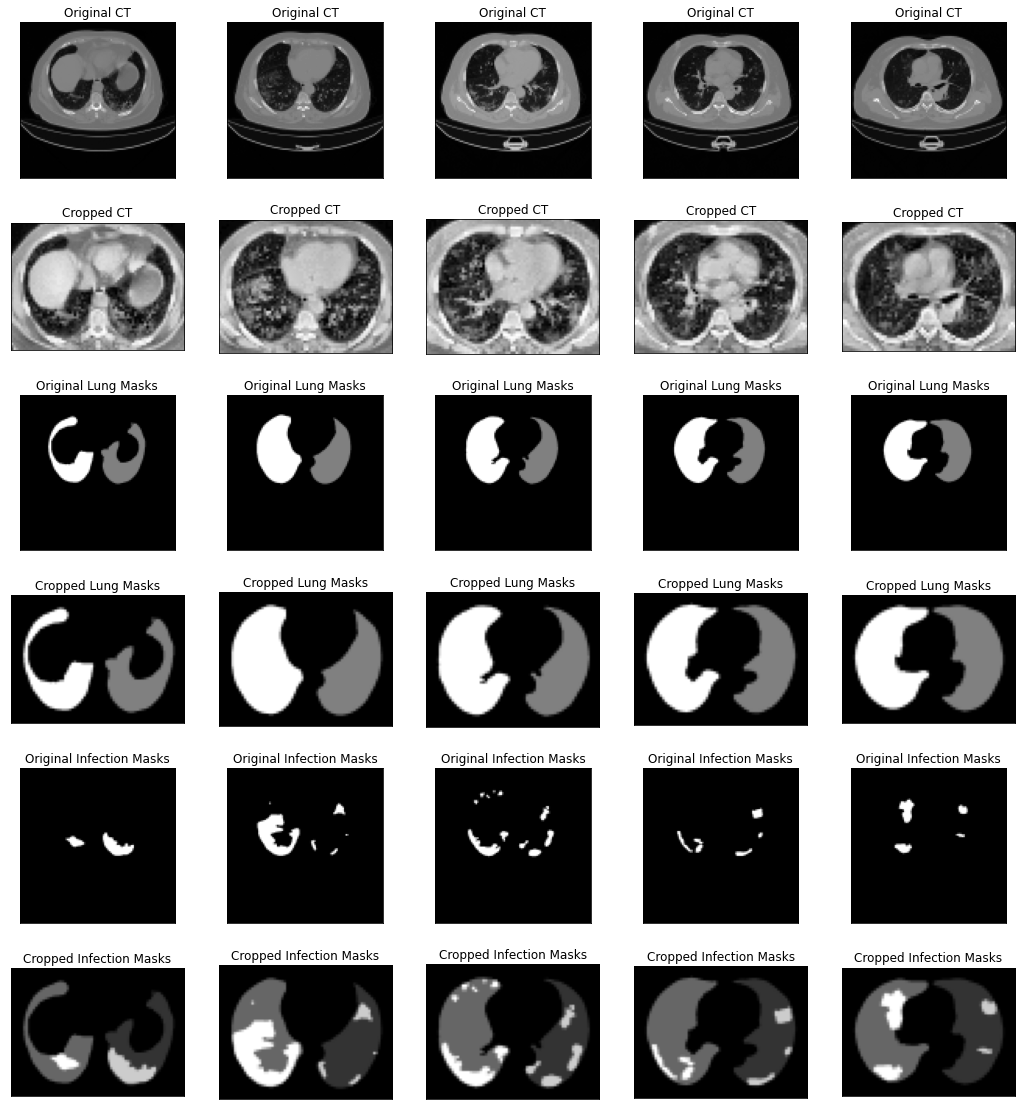

In [108]:
five_ct_slice=ct_sample[...,np.arange(100,200,20)]

five_ct_slice = np.reshape(np.rollaxis(five_ct_slice, 2),
                            (five_ct_slice.shape[2],
                             five_ct_slice.shape[0],
                             five_ct_slice.shape[1],
                             1))

five_inf_slice=infection_sample[...,np.arange(100,200,20)]

five_inf_slice = np.reshape(np.rollaxis(five_inf_slice, 2),
                            (five_inf_slice.shape[2],
                             five_inf_slice.shape[0],
                             five_inf_slice.shape[1],
                             1))

five_lung_sample = lung_sample[...,np.arange(100,200,20)]

five_lung_sample = np.reshape(np.rollaxis(five_lung_sample, 2),
                              (five_lung_sample.shape[2],
                               five_lung_sample.shape[0],
                               five_lung_sample.shape[1],
                               1))

fig, axes = plt.subplots(6, 5, figsize=(18,20))

for i in range (five_lung_sample.shape[0]):
  img_cts = cv.resize(five_ct_sample[i], dsize=(100, 100), interpolation=cv.INTER_AREA)
  img_lung = cv.resize(five_lung_sample[i], dsize=(100, 100), interpolation=cv.INTER_AREA)
  img_lung_o = cv.resize(five_lung_sample[i], dsize=(100, 100), interpolation=cv.INTER_AREA)
  img_inf = cv.resize(five_inf_slice[i], dsize=(100, 100), interpolation=cv.INTER_AREA)

  img_cts = (img_cts - img_cts.min())/(img_cts.max() - img_cts.min())

  bounds = lung_mask_crop(img_cts, img_lung)

  axes[0,i].imshow(img_cts, cmap='gray')
  axes[0,i].set_title('Original CT')
  axes[0,i].set_xticks([]); axes[0,i].set_yticks([])
  
  img_cts = clahe_enhancer(img_cts, clahe_image, [])
  img_cts = crop_lung(img_cts, bounds)
  axes[1,i].imshow(img_cts, cmap='gray')
  axes[1,i].set_title('Cropped CT')
  axes[1,i].set_xticks([]); axes[1,i].set_yticks([])

  axes[2,i].imshow(img_lung_o, cmap='gray')
  axes[2,i].set_title('Original Lung Masks')
  axes[2,i].set_xticks([]); axes[2,i].set_yticks([])

  img_lung_o = crop_lung(img_lung_o, bounds)
  axes[3,i].imshow(img_lung_o, cmap='gray')
  axes[3,i].set_title('Cropped Lung Masks')
  axes[3,i].set_xticks([]); axes[3,i].set_yticks([])
  
  axes[4,i].imshow(img_inf, cmap='gray')
  axes[4,i].set_title('Original Infection Masks')
  axes[4,i].set_xticks([]); axes[4,i].set_yticks([])

  img_inf = crop_lung(img_inf, bounds)
  axes[5,i].imshow(img_lung_o, cmap='gray')
  axes[5,i].imshow(img_inf, alpha=0.6, cmap='gray')
  axes[5,i].set_title('Cropped Infection Masks')
  axes[5,i].set_xticks([]); axes[5,i].set_yticks([])

###Loading all the data

In [109]:
all_cts = []
all_inf = []
all_lungs = []
bad_id = []

def nifti2arr(file_path):
  ni_object = nib.load(file_path)
  array   = ni_object.get_fdata()
  array   = np.rot90(np.array(array))
  _range = range(round(array.shape[2]*0.2), round(array.shape[2]*0.8))
  array = array[...,_range]
  array  = np.reshape(np.rollaxis(array, 2),
                     (array.shape[2],
                      array.shape[0],
                      array.shape[1],
                      1))
  return array


for i in tqdm(range(20)) :

  CT_scan  = nifti2arr(raw_data.loc[i,'ct_scan'])    
  Infection_mask  = nifti2arr(raw_data.loc[i,'infection_mask'])
  Lung_mask  = nifti2arr(raw_data.loc[i,'lung_mask'])
  print(' ')
  print('Shape of {}th CT scan: '.format(i),CT_scan.shape)
  print('Shape of {}th Infection mask: '.format(i),Infection_mask.shape)
  print('Shape of {}th Lung mask: '.format(i),Lung_mask.shape)
  print(' ')

  for slide in range(CT_scan.shape[0]):
    try:
      img_cts = cv.resize(CT_scan[slide], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
      img_lung = cv.resize(Lung_mask[slide], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
      img_lung_o = cv.resize(Lung_mask[slide], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
      img_inf = cv.resize(Infection_mask[slide], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)

      xmax, xmin = img_cts.max(), img_cts.min()
      img_cts = (img_cts - xmin)/(xmax - xmin)

      bounds = lung_mask_crop(img_cts, img_lung)

      img_cts = clahe_enhancer(img_cts, clahe_image, [])
      img_cts = crop_lung(img_cts, bounds)
      all_cts.append(img_cts)

      img_lung_o = crop_lung(img_lung_o, bounds)
      all_lungs.append(img_lung_o)

      img_inf = crop_lung(img_inf, bounds)
      all_inf.append(img_inf)
    except:
      bad_id.append(slide)
print('Total number of slides of CT-scan',len(all_cts))  
print('Total number of slides of Infections masks',len(all_inf))   
print('Total number of slides of Lungs masks',len(all_lungs))   
print(len(bad_id))       

  0%|          | 0/20 [00:00<?, ?it/s]

 
Shape of 0th CT scan:  (181, 512, 512, 1)
Shape of 0th Infection mask:  (181, 512, 512, 1)
Shape of 0th Lung mask:  (181, 512, 512, 1)
 


  5%|▌         | 1/20 [00:04<01:26,  4.54s/it]

 
Shape of 1th CT scan:  (120, 512, 512, 1)
Shape of 1th Infection mask:  (120, 512, 512, 1)
Shape of 1th Lung mask:  (120, 512, 512, 1)
 


 10%|█         | 2/20 [00:11<01:33,  5.18s/it]

 
Shape of 2th CT scan:  (120, 512, 512, 1)
Shape of 2th Infection mask:  (120, 512, 512, 1)
Shape of 2th Lung mask:  (120, 512, 512, 1)
 


 15%|█▌        | 3/20 [00:17<01:36,  5.66s/it]

 
Shape of 3th CT scan:  (162, 512, 512, 1)
Shape of 3th Infection mask:  (162, 512, 512, 1)
Shape of 3th Lung mask:  (162, 512, 512, 1)
 


 20%|██        | 4/20 [00:27<01:46,  6.69s/it]

 
Shape of 4th CT scan:  (174, 512, 512, 1)
Shape of 4th Infection mask:  (174, 512, 512, 1)
Shape of 4th Lung mask:  (174, 512, 512, 1)
 


 25%|██▌       | 5/20 [00:36<01:54,  7.64s/it]

 
Shape of 5th CT scan:  (127, 512, 512, 1)
Shape of 5th Infection mask:  (127, 512, 512, 1)
Shape of 5th Lung mask:  (127, 512, 512, 1)
 


 30%|███       | 6/20 [00:44<01:45,  7.52s/it]

 
Shape of 6th CT scan:  (149, 512, 512, 1)
Shape of 6th Infection mask:  (149, 512, 512, 1)
Shape of 6th Lung mask:  (149, 512, 512, 1)
 


 35%|███▌      | 7/20 [00:52<01:41,  7.79s/it]

 
Shape of 7th CT scan:  (181, 512, 512, 1)
Shape of 7th Infection mask:  (181, 512, 512, 1)
Shape of 7th Lung mask:  (181, 512, 512, 1)
 


 40%|████      | 8/20 [01:02<01:42,  8.56s/it]

 
Shape of 8th CT scan:  (154, 512, 512, 1)
Shape of 8th Infection mask:  (154, 512, 512, 1)
Shape of 8th Lung mask:  (154, 512, 512, 1)
 


 45%|████▌     | 9/20 [01:11<01:33,  8.52s/it]

 
Shape of 9th CT scan:  (181, 512, 512, 1)
Shape of 9th Infection mask:  (181, 512, 512, 1)
Shape of 9th Lung mask:  (181, 512, 512, 1)
 


 55%|█████▌    | 11/20 [01:23<01:02,  6.91s/it]

 
Shape of 10th CT scan:  (23, 630, 630, 1)
Shape of 10th Infection mask:  (23, 630, 630, 1)
Shape of 10th Lung mask:  (23, 630, 630, 1)
 
 
Shape of 11th CT scan:  (250, 630, 630, 1)
Shape of 11th Infection mask:  (250, 630, 630, 1)
Shape of 11th Lung mask:  (250, 630, 630, 1)
 


 60%|██████    | 12/20 [01:44<01:27, 10.95s/it]

 
Shape of 12th CT scan:  (66, 401, 630, 1)
Shape of 12th Infection mask:  (66, 401, 630, 1)
Shape of 12th Lung mask:  (66, 401, 630, 1)
 


 65%|██████▌   | 13/20 [01:47<01:00,  8.68s/it]

 
Shape of 13th CT scan:  (40, 630, 630, 1)
Shape of 13th Infection mask:  (40, 630, 630, 1)
Shape of 13th Lung mask:  (40, 630, 630, 1)
 


 75%|███████▌  | 15/20 [01:52<00:27,  5.45s/it]

 
Shape of 14th CT scan:  (26, 630, 630, 1)
Shape of 14th Infection mask:  (26, 630, 630, 1)
Shape of 14th Lung mask:  (26, 630, 630, 1)
 


 80%|████████  | 16/20 [01:54<00:17,  4.37s/it]

 
Shape of 15th CT scan:  (26, 630, 630, 1)
Shape of 15th Infection mask:  (26, 630, 630, 1)
Shape of 15th Lung mask:  (26, 630, 630, 1)
 


 85%|████████▌ | 17/20 [01:56<00:10,  3.65s/it]

 
Shape of 16th CT scan:  (27, 630, 630, 1)
Shape of 16th Infection mask:  (27, 630, 630, 1)
Shape of 16th Lung mask:  (27, 630, 630, 1)
 
 
Shape of 17th CT scan:  (55, 630, 630, 1)
Shape of 17th Infection mask:  (55, 630, 630, 1)
Shape of 17th Lung mask:  (55, 630, 630, 1)
 


 95%|█████████▌| 19/20 [02:01<00:03,  3.11s/it]

 
Shape of 18th CT scan:  (23, 630, 630, 1)
Shape of 18th Infection mask:  (23, 630, 630, 1)
Shape of 18th Lung mask:  (23, 630, 630, 1)
 


100%|██████████| 20/20 [02:03<00:00,  6.19s/it]

 
Shape of 19th CT scan:  (27, 630, 630, 1)
Shape of 19th Infection mask:  (27, 630, 630, 1)
Shape of 19th Lung mask:  (27, 630, 630, 1)
 
Total number of slides of CT-scan 2063
Total number of slides of Infections masks 2063
Total number of slides of Lungs masks 2063
49


In [110]:
del_lst = []
for i in tqdm(range(len(all_cts))) :
  try :
    all_cts[i] = cv.resize(all_cts[i], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    all_cts[i] = np.reshape(all_cts[i], (img_size, img_size, 1))
    all_lungs[i] = cv.resize(all_lungs[i], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    all_lungs[i] = np.reshape(all_lungs[i], (img_size, img_size, 1))
    all_inf[i] = cv.resize(all_inf[i], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    all_inf[i] = np.reshape(all_inf[i], (img_size, img_size, 1))
  except :
    del_lst.append(i)      

for idx in del_lst[::-1] :
  del all_cts[idx]
  del all_lungs[idx]
  del all_inf[idx]

100%|██████████| 2063/2063 [00:00<00:00, 6566.26it/s]


In [111]:
all_cts[2060].shape

(128, 128, 1)

[]

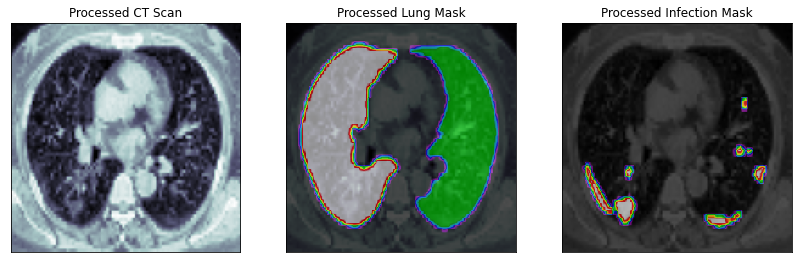

In [112]:
fig, axes = plt.subplots(1, 3, figsize=(14,5))

axes[0].imshow(all_cts[100][..., 0], cmap='bone')
axes[0].set_title("Processed CT Scan")
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].imshow(all_cts[100][..., 0], cmap='bone')
axes[1].imshow(all_lungs[100][..., 0],alpha=0.7 ,cmap='nipy_spectral')
axes[1].set_title("Processed Lung Mask")
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].imshow(all_cts[100][..., 0], cmap='gray')
axes[2].imshow(all_inf[100][..., 0], alpha=0.7, cmap='nipy_spectral')
axes[2].set_title("Processed Infection Mask")
axes[2].set_xticks([])
axes[2].set_yticks([])

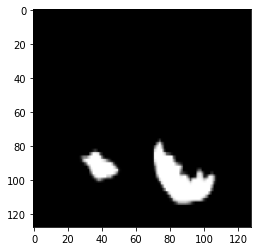

In [113]:
plt.imshow(all_inf[35][...,0],cmap='gray')

### Deleting Infection masks with all values as zeros (have no infections).

In [114]:
lst=[]
for i in range(len(all_inf)):
  if (np.all((all_inf[i].flatten()==0))):
    lst.append(1)
print('Number of Infected mask\'slide that contain all values as zeros(Have no infections): ',len(lst))

Number of Infected mask'slide that contain all values as zeros(Have no infections):  499


Number of CT slices available after deletion of non-infection masks  1564


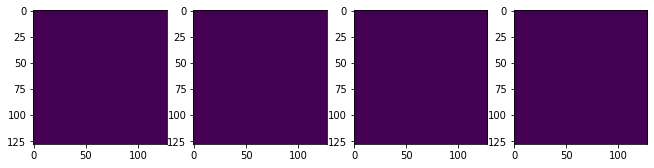

In [115]:
total_slides = len(all_cts)
index_arr = []
inf_check = np.ones((1, len(all_inf)))
for i in range(len(all_inf)):
  if np.unique(all_inf[i]).size == 1:
    inf_check[0, i] = 0
    index_arr.append(i)

# Testing the black masks
fig, axes = plt.subplots(1, 4, figsize=(11,5))
tmp = 0
for i in index_arr:
  img_inf = cv.resize(all_inf[i], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
  axes[tmp].imshow(img_inf)
  tmp += 1
  if tmp==4:
    break

for i in index_arr[::-1]:
  del all_cts[i]
  del all_inf[i]
  del all_lungs[i]

print("Number of CT slices available after deletion of non-infection masks ", len(all_cts))

In [116]:
all_cts = np.array(all_cts)
all_lungs = np.array(all_lungs)
all_inf = np.array(all_inf)

print(all_cts.shape)
print(all_lungs.shape)
print(all_inf.shape)

(1564, 128, 128, 1)
(1564, 128, 128, 1)
(1564, 128, 128, 1)


### Viewing the final fully processed images

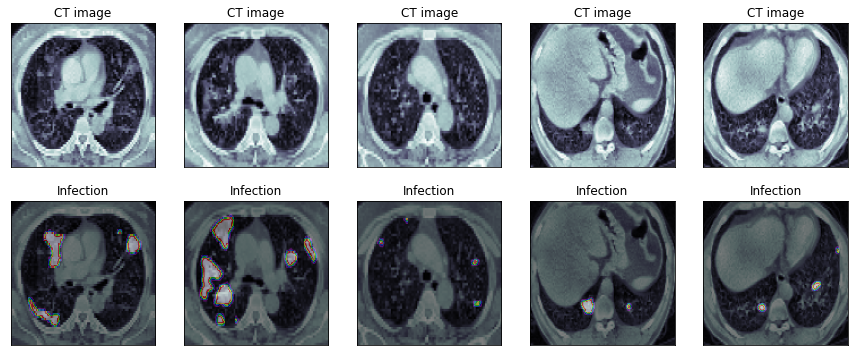

In [117]:
def plot_cts_infects(ct, infect, axes) :

    axes[0].imshow(ct[:,:,0], cmap='bone')
    axes[0].set_title('CT image')
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    axes[1].imshow(ct[:,:,0], cmap='bone')
    axes[1].imshow(infect[:,:,0], alpha=0.5, cmap='nipy_spectral')
    axes[1].set_title('Infection')
    axes[1].set_xticks([])
    axes[1].set_yticks([])    

fig, axes = plt.subplots(2, 5, figsize=(15,6))

for ii, idx in enumerate(range(100, 200, 20)):
    plot_cts_infects(all_cts[idx], all_inf[idx], list(axes[:,ii]))    

###Saving Data

In [118]:
with open('Processed_Data.cp', 'wb') as myfile:
    pickle.dump({'cts': all_cts, 'lungs': all_lungs, 'infects': all_inf}, myfile)